In [3]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import torch
from tqdm.auto import tqdm

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import read_and_proc
#from tools.mlr import mlr
#from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
import read_stuff as read
import ts_models
import glob,os
import matplotlib.pyplot as plt
import ts_models,analysis

import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
def prepare_tensors(filepath='./haiyan_store',splitnum=None,explag=23,notensor='No'):
    if './haiyan_store' in filepath:
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*intensity*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*intensity*')[0])['test'][explag]
    elif filepath=='./maria_store':
        Xtrain = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['train']
        Xvalid = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['valid']
        Xtest = read_and_proc.depickle(glob.glob(filepath+'/X/'+str(splitnum)+'/*corr*')[0])['uvwthhdialwsw']['test']
        ytrain = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['train'][explag]
        yvalid = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['valid'][explag]
        ytest = read_and_proc.depickle(glob.glob(filepath+'/y/'+str(splitnum)+'/*corr*')[0])['test'][explag]
    
    X_totrain, y_totrain = read.delete_padding(Xtrain,ytrain)
    X_tovalid, y_tovalid = read.delete_padding(Xvalid,yvalid)
    X_totest, y_totest = read.delete_padding(Xtest,ytest)
    
    if notensor=='No':
        calc_device = 'cpu'
        ###################################################################################
        # Convert numpy arrays into tensors
        ###################################################################################
        train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
        train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
        val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
        val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
        test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
        test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
        #train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
        #val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
        #test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
        
        return {'train':[train_Xtensor,train_ytensor],'valid':[val_Xtensor,val_ytensor],'test':[test_Xtensor,test_ytensor]}
    elif notensor=='Yes':
        return {'train':[X_totrain, y_totrain],'valid':[X_tovalid, y_tovalid],'test':[X_totest, y_totest]}

storedata = prepare_tensors('./haiyan_store',17,23,'No')
store_notensor = prepare_tensors('./haiyan_store',17,23,'Yes')
    #read.delete_padding(read_and_proc.depickle(glob.glob('./store/X/0/*')[0])['uvwthhdialwsw']['train'],read_and_proc.depickle(glob.glob('./store/y/0/*')[0])['train'][23])[1]

In [87]:
class BranchEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(BranchEncoder, self).__init__()

        self.fc_mean = nn.Linear(input_dim, latent_dim)
        self.fc_logvar = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        mu = self.fc_mean(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim1, latent_dim2, output_dim):
        super(Decoder, self).__init__()

        # Linear layers for both latent spaces to directly output to the regression output
        self.fc1 = nn.Linear(latent_dim1, output_dim, bias=True)
        self.fc2 = nn.Linear(latent_dim2, output_dim, bias=True)

    def forward(self, z1, z2):
        # Compute linear regression outputs from both latent spaces
        out1 = self.fc1(z1)
        out2 = self.fc2(z2)

        # Combine the outputs (sum them up)
        return out1 + out2


class VAE(nn.Module):
    def __init__(self, input_dim1, input_dim2, latent_dim1, latent_dim2, output_dim, brchindices):
        super(VAE, self).__init__()

        self.encoder1 = BranchEncoder(input_dim1, latent_dim1)
        self.encoder2 = BranchEncoder(input_dim2, latent_dim2)
        self.decoder = Decoder(latent_dim1, latent_dim2, output_dim)
        self.brchindices = brchindices

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, X):
        brchindex = list(np.asarray(self.brchindices).cumsum())#[0,50,38,50,8,50,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        mu1, log_var1 = self.encoder1(X_lw)
        mu2, log_var2 = self.encoder2(X_sw)

        z1 = self.reparameterize(mu1, log_var1)
        z2 = self.reparameterize(mu2, log_var2)

        return self.decoder(z1, z2), mu1, log_var1, mu2, log_var2

def vae_loss(reconstructed_x, x, mu1, log_var1, mu2, log_var2, coeff):
    recon_loss = F.l1_loss(reconstructed_x, x, reduction='sum')
    kl_loss1 = -0.5 * torch.sum(1 + log_var1 - mu1.pow(2) - log_var1.exp())
    kl_loss2 = -0.5 * torch.sum(1 + log_var2 - mu2.pow(2) - log_var2.exp())
    return coeff*recon_loss + (1-coeff)*(kl_loss1 + kl_loss2)

In [32]:
train_data,val_data,test_data = prepare_tensors('./haiyan_store/',17,23)
train_data,val_data,test_data = prepare_tensors('./haiyan_store/',17,23)

(146, 236)


In [94]:
def train_model(model=None,optimizer=None,scheduler=None,numepochs=None,early_stopper=None,variance_store=None,lossfunc=None,regularization='None',l1_lambda=0.01,l2_lambda=0.1,train_loader=None,val_loader=None,test_loader=None,count=None):
    # Custom loss: MSE_physicalLoss(eigenvectors,wcomps,variance_store)
    #liveloss = PlotLosses()
    schedulerCY,schedulerLS = scheduler[1],scheduler[0]
    train_losses,trainu_losses,trainv_losses,trainw_losses,trainth_losses = [],[],[],[],[]
    val_losses = []
    val_NSEs = []
    statedicts = []
    for epoch in (range(int(numepochs))):
        """
        Initialize loss
        """
        train_loss = 0
        """
        Operate per batch
        """
        for features, labels in train_loader:
            optimizer.zero_grad()
            
            reconX,mu1,logvar1,mu2,logvar2 = model(features)
            batch_loss = vae_loss(reconX, labels.unsqueeze(1),mu1,logvar1,mu2,logvar2)
            
            batch_loss.backward()                
            
            optimizer.step()
            schedulerCY.step()
            
            train_loss += batch_loss.item()
            
            
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.train()
        criterion = vae_loss
        val_loss = eval_model(model,
                              val_loader,
                              criterion,
                             l2_lambda)
        schedulerLS.step(val_loss)
        statedicts.append(model.state_dict())
        
        ##################################################################
        # Early Stopping (valid / train)
        ##################################################################
        counter = 0
        if len(val_losses)>=1:
            best_score = val_losses[-1]
            if val_loss > best_score:
                counter += 1
                #val_NSEs.append(val_NSE)
                val_losses.append(val_loss)
                if counter >= count:
                    break
            else:
                #val_NSEs.append(val_NSE)
                val_losses.append(val_loss)
        else:
            #val_NSEs.append(val_NSE)
            val_losses.append(val_loss)
            
        if early_stopper:
            if early_stopper.__call__(val_loss, model):
                break
        
        if epoch % 300 == 0:
            print(((train_loss),(val_loss)))
            
    #return model, {'train':train_losses,'utrain':trainu_losses,'vtrain':trainv_losses,'wtrain':trainw_losses,'thtrain':trainth_losses,'val':val_losses} 
    return model, {'train':train_losses,'val':val_losses}, statedicts

In [35]:
import optuna
nummem = [0,50,38,50,8,50,20,20]

def eval_model(model, dataloader, loss_func, l2_lambda):
    with torch.no_grad():
        loss = 0
        metric = 0
        
        global_sum = 0
        label_size = 0
        for feature, labels in dataloader:
            global_sum += labels.sum()
            label_size += len(labels)
            
        global_mean = global_sum / label_size
        model.train()
        for features, labels in dataloader:
            reconX,mu1,logvar1,mu2,logvar2 = model(features)
            batch_loss = vae_loss(reconX, labels.unsqueeze(1),mu1,logvar1,mu2,logvar2)
            
            #l2_parameters = []
            #for parameter in model.parameters():
            #    l2_parameters.append(parameter.view(-1))
            #    l2 = l2_lambda * model.compute_l2_loss(torch.cat(l2_parameters))
            #batch_loss += l2
            loss+=batch_loss.item()
            
        num_batches = len(dataloader)
        
        loss = loss/num_batches
        return loss
    
    
def objective(trial):
    models,losses = [],[]
    model = VAE(nummem[-2],nummem[-1],1,1,1,nummem)
    #droprate = trial.suggest_float("droprate",0.05,0.45)
    lr = trial.suggest_float("lr",1e-6,1e-3)#,log=True)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    criterion = vae_loss
    n_epochs = 500
    scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4,cycle_momentum=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=1e-12)

    l2_lambda = trial.suggest_float("l2_lambda",0.01,0.02)
    #model,loss = train_model(model=model,train_data=data_loaders['train'],val_data=data_loaders['val'],optimizer=optimizer,scheduler=[scheduler,scheduler2],numepochs=num_epochs,early_stopper=None,variance_store=None,\
    #                         lossfunc=lossfuncs[0],regularization='L2',l1_lambda=0.1,l2_lambda=l2_lambda,trial=trial)
    #torch.save(model,'../tmp/bayesian/saved_model.8.'+str(trial.number)+'.pt')
    # Define Loss, Optimizer
    train_losses = []
    val_losses = []
    for epoch in range(1,n_epochs+1):
        loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            reconX,mu1,logvar1,mu2,logvar2 = model(features)
            batch_loss = vae_loss(reconX, labels.unsqueeze(1),mu1,logvar1,mu2,logvar2)
            batch_loss.backward()
            optimizer.step()
            loss += batch_loss.item()
        loss = loss/len(train_loader)
        train_losses.append(loss)
        criterion = vae_loss
        val_loss = eval_model(model,
                              val_loader,
                              criterion,
                             l2_lambda)
        val_losses.append(val_loss)
        if epoch%100 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs))
            print("Loss: {:.4f}".format(loss))
        #if val_loss <= min(val_losses):
        #    torch.save(model,'best_model'+str(trial.number))
    #torch.save(model,'./tmp/bayesian/best_model.8.'+str(trial.number)+'.pt')
    return val_loss

In [36]:
batch_size = 9
num_workers = 2
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False)

study = optuna.create_study(directions=["minimize"])
study.optimize(objective, n_trials=4)

[I 2023-10-26 16:33:18,742] A new study created in memory with name: no-name-e9bf5d4d-fe3c-47e6-b6fb-b55a39141ca4


Epoch: 100/500.............
Loss: 5.8927
Epoch: 200/500.............
Loss: 6.2246
Epoch: 300/500.............
Loss: 6.4958
Epoch: 400/500.............
Loss: 6.4045


[I 2023-10-26 16:33:55,545] Trial 0 finished with value: 4.2210394276512995 and parameters: {'lr': 0.00032250873384065366, 'l2_lambda': 0.016625869904525116}. Best is trial 0 with value: 4.2210394276512995.


Epoch: 500/500.............
Loss: 7.0075
Epoch: 100/500.............
Loss: 15.7856
Epoch: 200/500.............
Loss: 16.5716
Epoch: 300/500.............
Loss: 17.8443
Epoch: 400/500.............
Loss: 15.7291


[I 2023-10-26 16:34:32,332] Trial 1 finished with value: 8.630236254798042 and parameters: {'lr': 0.00024695894583082786, 'l2_lambda': 0.015781802191960223}. Best is trial 0 with value: 4.2210394276512995.


Epoch: 500/500.............
Loss: 17.2661
Epoch: 100/500.............
Loss: 21.6773
Epoch: 200/500.............
Loss: 21.8585
Epoch: 300/500.............
Loss: 22.5385
Epoch: 400/500.............
Loss: 22.9499


[I 2023-10-26 16:35:09,077] Trial 2 finished with value: 16.006782213846844 and parameters: {'lr': 0.0008369909709129781, 'l2_lambda': 0.011395667533675885}. Best is trial 0 with value: 4.2210394276512995.


Epoch: 500/500.............
Loss: 21.9554
Epoch: 100/500.............
Loss: 1.9722
Epoch: 200/500.............
Loss: 2.1384
Epoch: 300/500.............
Loss: 2.1432
Epoch: 400/500.............
Loss: 2.1777


[I 2023-10-26 16:35:45,812] Trial 3 finished with value: 1.379857940806283 and parameters: {'lr': 0.0005409347800717093, 'l2_lambda': 0.013444225160487652}. Best is trial 3 with value: 1.379857940806283.


Epoch: 500/500.............
Loss: 2.0960


In [104]:
models,losses = [],[]
model = VAE(nummem[-2],nummem[-1],1,1,1,nummem)
optimizers = [torch.optim.Adam(model.parameters(), lr=study.best_params['lr'])]#, optim.AdaBound(model.parameters(),lr=1e-7)] 1e-6 [torch.optim.Adam(model.parameters(),lr=0.5e-5),torch.optim.SGD(model.parameters(),lr=0.5e-5,momentum=0.8)]
loss = torch.nn.L1Loss()
for optimizer in optimizers:
    scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-8, max_lr=5e-5,cycle_momentum=False) #1e-9/1e-5
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=1e-12)  #1e-18
    num_epochs = 1000*20#26
    #early_stopper = ts_models.EarlyStopping(patience=250, verbose=False, delta=1e-5, path='checkpoint.pt', trace_func=print)#EarlyStopper(patience=8, min_delta=1e-3)
    early_stopper = ts_models.EarlyStopping(patience=400, verbose=False, delta=1.5e-5, path='checkpoint.pt', trace_func=print)
    #variance_store = [varu,varv,varw,varth]
    #variance_store = [varu,varv,varth]
    model,loss,_ = train_model(model=model,optimizer=optimizer,scheduler=[scheduler,scheduler2],numepochs=num_epochs,early_stopper=early_stopper,variance_store=None,\
                                         lossfunc=loss,train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,l2_lambda=study.best_params['l2_lambda'],count=10)
    models.append(model)
    losses.append(loss)

(9.138704285025597, 8.307463513480293)
(0.0007442582879472562, 0.0005530178378750053)
(0.0006997111346815169, 0.0004873728062698825)
(0.000555292006538366, 0.00039137512147944007)
(0.0004773776466511966, 0.00027679111776200845)


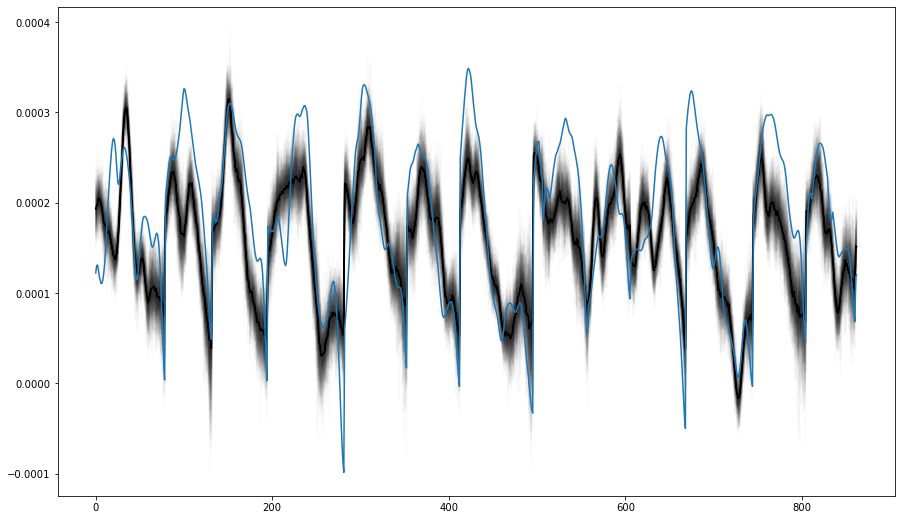

In [105]:
fig,ax=plt.subplots(1,1,figsize=(15,9))
plt.plot(np.mean(np.asarray([models[0](storedata['train'][0])[0].detach().numpy() for _ in range(100)]),axis=0),c='k')
for i in range(100):
    plt.plot(models[0](storedata['train'][0])[0].detach().numpy(),alpha=0.02,c='k')
plt.plot((storedata['train'][1]).detach().numpy())

00.plt.show()

In [ ]:
class resume_training:
    def __init__(self,splitnum=None,droprate=None,timelag=None,batch_size=None,num_workers=2):
        self.splitnum=splitnum
        self.droprate=droprate
        self.timelag = timelag
        self.batch_size = batch_size
        self.num_workers=2
        
    def get_data(self,filepath=None):
        train_data,val_data,test_data = prepare_tensors(filepath,self.splitnum,self.timelag)
        train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=self.batch_size,shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset=val_data,batch_size=self.batch_size,shuffle=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=self.batch_size,shuffle=False)
        return train_loader,val_loader,test_loader
    
    def continue_training(self,datafilepath='./maria_store/',savefilepath='./maria_store/dropout_corr/',exp='e',scheduler_lr=[1e-14,5e-10]):
        train_loader,val_loader,_ = self.get_data(datafilepath)
        original_model = ts_models.OptimMLR_lwsw_3D_ts_dropout2(self.droprate,[0,50,26,50,50,50,10,10])
        #######################################################################################################################################
        # Transfer state dict
        pretrained_model = torch.load(savefilepath+str(self.splitnum)+'/'+str(self.droprate)+'/modelstest'+str(self.splitnum)+'_lwswts_1115_exp1'+str(exp)+'.pt')[0]
        model_dict = original_model.state_dict()
        pretrained_dict = pretrained_model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        original_model.load_state_dict(model_dict)
        #######################################################################################################################################
        #######################################################################################################################################
        optimizer = torch.optim.Adam(original_model.parameters(), lr=study.best_params['lr'])
        lossfunc = torch.nn.L1Loss()
        #scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-16, max_lr=5e-10,cycle_momentum=False) #1e-9/1e-5
        scheduler2 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=scheduler_lr[0], max_lr=scheduler_lr[1],cycle_momentum=False) #1e-9/1e-5
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr=1e-20)
        #######################################################################################################################################
        
        lowest_val_loss = float('inf')
        best_model = None
        schedulerCY,schedulerLS = scheduler2,scheduler
        train_losses = []
        val_losses = []
        
        for epoch in tqdm(range(20000)):
            original_model.train()
            train_loss = 0
            # Training loop here
            for features, labels in train_loader:
                optimizer.zero_grad()
                prediction = original_model(features)
                batch_loss = lossfunc(prediction, labels.unsqueeze(1))#loss_func(prediction, labels)
                batch_loss.backward()
                optimizer.step()
                schedulerCY.step()
                
                train_loss += batch_loss.item()    
            train_loss = train_loss / len(train_loader)
            train_losses.append(train_loss)

            # Validation loop
            original_model.eval()
            with torch.no_grad():
                val_loss = 0
                for features, labels in val_loader:
                    pred = original_model(features)
                    batch_loss = lossfunc(pred, labels.unsqueeze(1))
                    val_loss+=batch_loss.item()
            
                val_loss = val_loss / len(val_loader)
                val_losses.append(val_loss)

            # Check if the current model has the lowest validation loss
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = original_model.state_dict()
    
            torch.save(best_model, savefilepath+str(splitnum)+'/'+str(droprate)+'/modelstest0_lwswts_1115_exp1'+str(exp)+'_best.pt')
            read_and_proc.save_to_pickle(savefilepath+str(splitnum)+'/'+str(droprate)+'/lossestest'+str(splitnum)+'_lwswts_1115_exp1'+str(exp)+'_best.pkt',{'train':train_losses,'val':val_losses},'PICKLE')
        return None

In [176]:
filepath = './maria_store/dropout_corr/'
splitnum = 0
for droprate in tqdm([0,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]):
    for exp in ['a','b','c','d','e','f','g','h','i']:
        resume_training(splitnum,droprate,23,9,2).continue_training(datafilepath='./maria_store/',savefilepath='./maria_store/dropout_corr/',\
                                                                    exp=exp,scheduler_lr=[1e-14,5e-10])

  0%|          | 0/14 [00:00<?, ?it/s]

(96, 247)


  0%|          | 0/20000 [00:00<?, ?it/s]

(96, 247)


  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
filepath = './maria_store/dropout_corr/'
splitnum = 0
for droprate in [0,0.001,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]:
    for exp in ['a','b','c','d','e','f','g','h','i']:
        resume_training(splitnum,droprate,23,9,2).continue_training(filepath='./maria_store/dropout_corr/',exp=exp,scheduler_lr=[1e-14,5e-10])
splitnum,droprate = 0,0.1
timelag = 23
batch_size = 9
num_workers = 2

train_data,val_data,test_data = prepare_tensors(filepath,splitnum,timelag)
study = read_and_proc.depickle('./maria_store/dropout_corr/'+str(splitnum)+'/'+str(droprate)+'/'+'bestparams.pkt')

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False)

(96, 247)


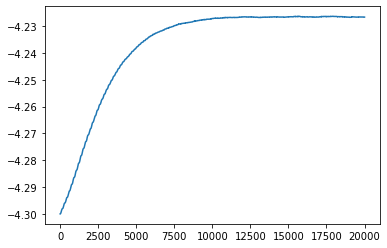

In [157]:
#plt.plot(np.log10(train_losses))
plt.plot(np.log10(val_losses))
plt.show()